### 請解壓縮data.rar，取得本程式之數據
### 訓練資料來自 : http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [ ]:
from google.colab import drive
%tensorflow_version 1.x
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.misc as sc 
import math
import cv2
import os
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')
path = os.path.join(os.getcwd() , 'gdrive' , 'My Drive' , 'pix2pix_mosaic_gan')
os.chdir(path)

TensorFlow 1.x selected.


Using TensorFlow backend.


Mounted at /content/gdrive


In [ ]:
# 讀取訓練與測試資料
img_resize = np.load('images_resize.npy')
img_mosaic = np.load('images_mosaic.npy')
real_train = img_resize[:900]
mosaic_train = img_mosaic[:900]
real_test = img_resize[900:]
mosaic_test = img_mosaic[900:]
del img_resize , img_mosaic

In [ ]:
def batch_norm_layer_part1(inputs , on_train , convolution):
    # the dimension you wanna normalize, here [0] for batch
    # for image, you wanna do [0 , 1 , 2] for [batch , height , width] but not channel
    if convolution:
        fc_mean , fc_var = tf.nn.moments(inputs , axes = [0 , 1 , 2] , name = 'mean_var')
    else:
        fc_mean , fc_var = tf.nn.moments(inputs , axes = [0] , name = 'mean_var')

    ema = tf.train.ExponentialMovingAverage(decay = 0.75)
    ema_apply_op = ema.apply([fc_mean , fc_var])
    mean = tf.cond(on_train , lambda : fc_mean , lambda : ema.average(fc_mean))
    var = tf.cond(on_train , lambda : fc_var , lambda : ema.average(fc_var))
    return mean , var , ema_apply_op

def batch_norm_layer_part2(inputs , mean , var):
    scale = tf.get_variable(shape = inputs.shape[-1].value , initializer = tf.random_normal_initializer(1 , 0.02) , name = 'scale')
    shift = tf.get_variable(shape = inputs.shape[-1].value , initializer = tf.zeros_initializer , name = 'shift')
    temp = (inputs - mean) / tf.sqrt(var + 1e-8)
    outputs = tf.multiply(temp , scale) + shift
    return outputs


def conv_block(inputs , n_filter , layer , kernel_size = 4 , stride = 2 , padding = 'same' ,
               activation_func = tf.nn.leaky_relu , batch_norm = True , reuse = False):
    with tf.variable_scope('Conv{}'.format(layer)) as scope:
        if reuse: tf.get_variable_scope().reuse_variables()
        conv = tf.contrib.layers.conv2d(inputs , n_filter , [kernel_size , kernel_size] ,
                                        stride = stride , padding = padding , activation_fn = None ,
                                        weights_initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform = False))
    if activation_func is not None:
        conv = activation_func(conv)    
    
    if batch_norm:
        with tf.variable_scope('Conv{}_compute_mean_var'.format(layer)):
            conv_mean , conv_var , conv_ema = batch_norm_layer_part1(conv , on_train , True)
        with tf.variable_scope(scope):
            conv = batch_norm_layer_part2(conv , conv_mean , conv_var)

    if batch_norm: 
        return conv , conv_ema
    else:
        return conv


def up_block(inputs , n_filter , layer , kernel_size = 4 , stride = 1 , padding = 'same' ,
             activation_func = tf.nn.relu , batch_norm = True , dropout = False , reuse = False):
    with tf.variable_scope('Up{}'.format(layer)) as scope:
        if reuse: tf.get_variable_scope().reuse_variables()
        up = tf.keras.layers.UpSampling2D(size = [2, 2])(inputs)
        up = tf.contrib.layers.conv2d(up , n_filter , [kernel_size , kernel_size] ,  
                                      stride = stride , padding = padding , activation_fn = None ,
                                      weights_initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform = False))

    if activation_func is not None:
        up = activation_func(up)  

    if batch_norm:
        with tf.variable_scope('Up{}_compute_mean_var'.format(layer)):
            up_mean , up_var , up_ema = batch_norm_layer_part1(up , on_train , True)
        with tf.variable_scope(scope):
            up = batch_norm_layer_part2(up , up_mean , up_var)

    if batch_norm:
        if dropout: up = tf.nn.dropout(up , keep_prob)         
        return up , up_ema
    else:
        return up


def batch_generator(X , y , batch_size):
    size = X.shape[0]
    X_copy = X.copy()
    y_copy = y.copy()
    indices = np.arange(size)
    np.random.shuffle(indices)
    X_copy = X_copy[indices]
    y_copy = y_copy[indices]
    i = 0
    while True:
        if i + batch_size <= size:
            yield X_copy[i : i + batch_size] , y_copy[i : i + batch_size]
            i += batch_size
        else:
            i = 0
            indices = np.arange(size)
            np.random.shuffle(indices)
            X_copy = X_copy[indices]
            y_copy = y_copy[indices]

In [ ]:
eps = 1e-8
g_ema , d_ema = [] , []
mosaic_img = tf.placeholder(tf.float32 , [None , 256 , 256 , 3] , name = 'mosaic_img')
real_img = tf.placeholder(tf.float32 , [None , 256 , 256 , 3] , name = 'real_img')
keep_prob = tf.placeholder(tf.float32 , name = 'keep_prob')
on_train = tf.placeholder(tf.bool , name = 'on_train')

In [ ]:
# Generator採用的是UNET的架構
# Generator，相當於偽造家
with tf.variable_scope('Generator'):
    with tf.variable_scope('Encoder_Stage'):
        conv1 = conv_block(mosaic_img , 64 , 1 , batch_norm = False)
        conv2 , g_en_ema_2 = conv_block(conv1 , 128 , 2)
        conv3 , g_en_ema_3 = conv_block(conv2 , 256 , 3)
        conv4 , g_en_ema_4 = conv_block(conv3 , 512 , 4)
        conv5 , g_en_ema_5 = conv_block(conv4 , 512 , 5)
        conv6 , g_en_ema_6 = conv_block(conv5 , 512 , 6)
        conv7 , g_en_ema_7 = conv_block(conv6 , 512 , 7)
        g_ema.extend([g_en_ema_2 , g_en_ema_3 , g_en_ema_4 , g_en_ema_5 , g_en_ema_6 , g_en_ema_7])

    with tf.variable_scope('Middle_Stage'):    
        conv8 , g_en_ema_8 = conv_block(conv7 , 512 , 8)
        g_ema.append(g_en_ema_8)

    with tf.variable_scope('Decoder_Stage'):
        up1 , g_de_ema_1 = up_block(conv8 , 512 , 1 , dropout = True)
        concat1 = tf.concat([conv7 , up1] , axis = -1)      
        up2 , g_de_ema_2 = up_block(concat1 , 512 , 2 , dropout = True)
        concat2 = tf.concat([conv6 , up2] , axis = -1)    
        up3 , g_de_ema_3 = up_block(concat2 , 512 , 3 , dropout = True)
        concat3 = tf.concat([conv5 , up3] , axis = -1)  
        up4 , g_de_ema_4 = up_block(concat3 , 512 , 4)
        concat4 = tf.concat([conv4 , up4] , axis = -1) 
        up5 , g_de_ema_5 = up_block(concat4 , 256 , 5)
        concat5 = tf.concat([conv3 , up5] , axis = -1)
        up6 , g_de_ema_6 = up_block(concat5 , 128 , 6)
        concat6 = tf.concat([conv2 , up6] , axis = -1)
        up7 , g_de_ema_7 = up_block(concat6 , 64 , 7)
        concat7 = tf.concat([conv1 , up7] , axis = -1)
        g_ema.extend([g_de_ema_1 , g_de_ema_2 , g_de_ema_3 , g_de_ema_4 , g_de_ema_5 , g_de_ema_6 , g_de_ema_7])
        
    with tf.variable_scope('Output_Stage'):
        fake_img = up_block(concat7 , 3 , 8 , stride = 1 , activation_func = tf.nn.tanh , batch_norm = False)

        
# Discriminator，相當於鑑定師
with tf.variable_scope('Discriminator'):
    fake_img_pair = tf.concat([mosaic_img , fake_img] , axis = -1)
    real_img_pair = tf.concat([mosaic_img , real_img] , axis = -1)
    d_fake_1 = conv_block(fake_img_pair , 64 , 1 , batch_norm = False)
    d_real_1 = conv_block(real_img_pair , 64 , 1 , batch_norm = False , reuse = True)
    d_fake_2 , d_ema_2_1 = conv_block(d_fake_1 , 128 , 2)
    d_real_2 , d_ema_2_2 = conv_block(d_real_1 , 128 , 2 , reuse = True)
    d_fake_3 , d_ema_3_1 = conv_block(d_fake_2 , 256 , 3)
    d_real_3 , d_ema_3_2 = conv_block(d_real_2 , 256 , 3 , reuse = True)
    d_fake_4 , d_ema_4_1 = conv_block(d_fake_3 , 512 , 4)
    d_real_4 , d_ema_4_2 = conv_block(d_real_3 , 512 , 4 , reuse = True)
    fake_output_d = conv_block(d_fake_4 , 1 , 5 , stride = 1 , activation_func = tf.nn.sigmoid , batch_norm = False)
    real_output_d = conv_block(d_real_4 , 1 , 5 , stride = 1 , activation_func = tf.nn.sigmoid , batch_norm = False , reuse = True)
    fake_output_d = tf.squeeze(fake_output_d , axis = -1)
    real_output_d = tf.squeeze(real_output_d , axis = -1)
    d_ema.extend([d_ema_2_1 , d_ema_2_2 , d_ema_3_1 , d_ema_3_2 , d_ema_4_1 , d_ema_4_2])

    
with tf.variable_scope('Discriminator_Loss'):
    # 鑑定師D會希望 fake_output_d 越小越好，等同於 -(1 - fake_output_d) 越小越好
    # 鑑定師D也會希望 real_output_d 越大越好，等同於 -real_output_d 越小越好
    # 所以 d_loss 會越來越小
    d_loss = tf.reduce_mean(-(tf.log(tf.clip_by_value(real_output_d , eps , tf.reduce_max(real_output_d))) +\
                            tf.log(tf.clip_by_value(1 - fake_output_d , eps , tf.reduce_max(1 - fake_output_d)))))
    
    
with tf.variable_scope('Generator_Loss'):
    l1_weight = 100
    # g_loss_l1負責捕捉影像低頻的特徵
    g_loss_l1 = l1_weight * tf.reduce_mean(tf.abs(fake_img - real_img))
    # 偽造家G會希望 fake_output_d 越大越好，等同於 (1 - fake_output_d) 越小越好
    # 所以g_loss_gan確實會越來越小
    # g_loss_gan負責捕捉影像高頻的特徵
    g_loss_gan = tf.reduce_mean(tf.log(tf.clip_by_value(1 - fake_output_d , eps , tf.reduce_max(1 - fake_output_d))))
    g_loss = g_loss_l1 + g_loss_gan

    
with tf.variable_scope('Optimizer'):
    g_ema_group , d_ema_group = tf.group(g_ema) , tf.group(d_ema)
    variable_Generator , variable_Discriminator = [] , []
    for v in tf.trainable_variables(): 
        if 'Generator' in v.name : variable_Generator.append(v)
        if 'Discriminator' in v.name : variable_Discriminator.append(v)
    lr_g , lr_d = 2e-4 , 2e-4
    train_Generator = tf.train.AdamOptimizer(lr_g , beta1 = 0.5).minimize(g_loss , var_list = variable_Generator)
    train_Discriminator = tf.train.AdamOptimizer(lr_d , beta1 = 0.5).minimize(d_loss , var_list = variable_Discriminator)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 4
train_batch_generator = batch_generator(mosaic_train , real_train , batch_size)
epochs = 300
num_batch = math.ceil(len(mosaic_train) / batch_size)
for epoch_i in range(0 , epochs):
    d_loss_mean , g_loss_mean = 0 , 0
    for batch_i in range(0 , num_batch):
        x_train_bathch , y_train_bathch = next(train_batch_generator)
        x_train_bathch = (x_train_bathch - 127.5) / 127.5
        y_train_bathch = (y_train_bathch - 127.5) / 127.5
        _ , _ , d_loss_ = sess.run([train_Discriminator , d_ema_group , d_loss] ,
                                    feed_dict = {mosaic_img : x_train_bathch ,
                                                  real_img : y_train_bathch ,
                                                  on_train : True , 
                                                  keep_prob : 0.5})
        _ , _ , g_loss_ = sess.run([train_Generator , g_ema_group , g_loss] ,
                                    feed_dict = {mosaic_img : x_train_bathch ,
                                                  real_img : y_train_bathch ,
                                                  on_train : True , 
                                                  keep_prob : 0.5})

        d_loss_mean += d_loss_
        g_loss_mean += g_loss_

    print('=' * 30)
    print('epoch : {}'.format(epoch_i))
    print('Discriminator_loss_mean : {:.3f}'.format(d_loss_mean / num_batch))
    print('Generator_loss_mean : {:.3f}'.format(g_loss_mean / num_batch))

    if epoch_i % 2 == 0:
      img_pred_train = sess.run(fake_img ,
                  feed_dict = {mosaic_img : (mosaic_train[:2] - 127.5) / 127.5 ,
                                on_train : False , 
                                keep_prob : 1})

      img_pred_test = sess.run(fake_img ,
                  feed_dict = {mosaic_img : (mosaic_test[:2] - 127.5) / 127.5 ,
                                on_train : False , 
                                keep_prob : 1})
      
      img_pred_train = (img_pred_train + 1) * 127.5
      img_pred_test = (img_pred_test + 1) * 127.5
      np.save('img_pred_train_{}'.format(epoch_i) , img_pred_train[0] / 255)
      np.save('img_pred_test_{}'.format(epoch_i) , img_pred_test[0] / 255)

epoch : 0
Discriminator_loss_mean : 1.303
Generator_loss_mean : 9.468
epoch : 1
Discriminator_loss_mean : 0.161
Generator_loss_mean : 5.983
epoch : 2
Discriminator_loss_mean : 0.008
Generator_loss_mean : 5.621
epoch : 3
Discriminator_loss_mean : 0.004
Generator_loss_mean : 5.149
epoch : 4
Discriminator_loss_mean : 0.003
Generator_loss_mean : 4.939
epoch : 5
Discriminator_loss_mean : 0.002
Generator_loss_mean : 4.771
epoch : 6
Discriminator_loss_mean : 0.280
Generator_loss_mean : 4.489
epoch : 7
Discriminator_loss_mean : 1.385
Generator_loss_mean : 3.824
epoch : 8
Discriminator_loss_mean : 1.350
Generator_loss_mean : 3.804
epoch : 9
Discriminator_loss_mean : 1.234
Generator_loss_mean : 3.853
epoch : 10
Discriminator_loss_mean : 1.198
Generator_loss_mean : 4.009
epoch : 11
Discriminator_loss_mean : 0.903
Generator_loss_mean : 4.037
epoch : 12
Discriminator_loss_mean : 0.020
Generator_loss_mean : 4.029
epoch : 13
Discriminator_loss_mean : 0.007
Generator_loss_mean : 3.909
epoch : 14
Discr

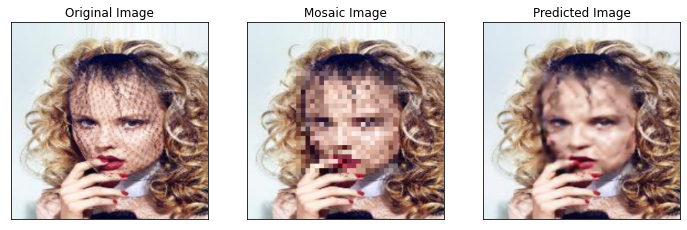

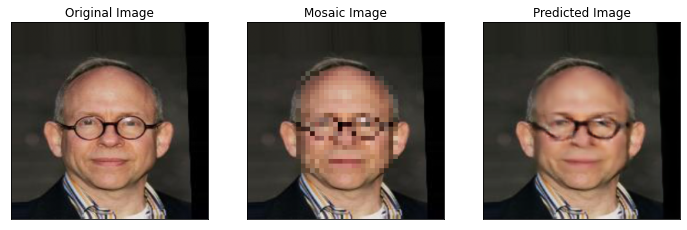

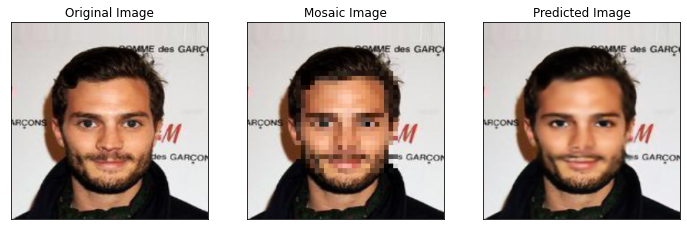

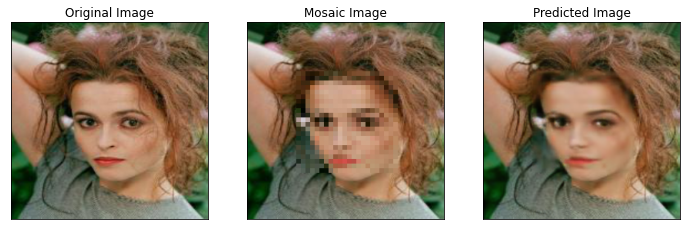

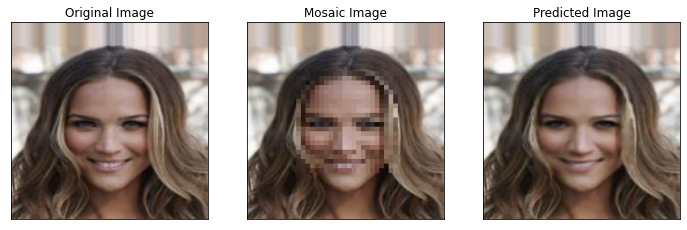

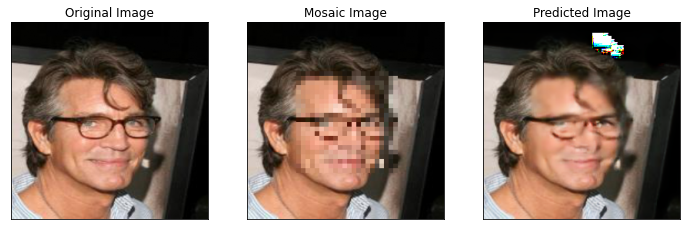

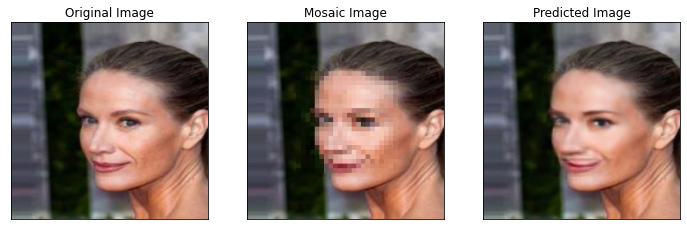

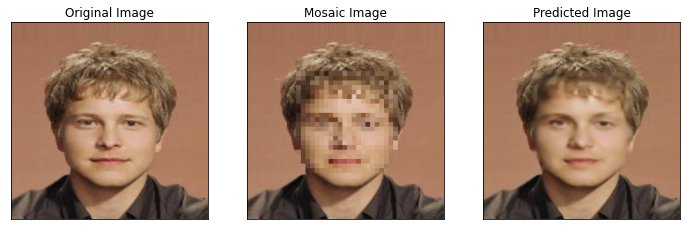

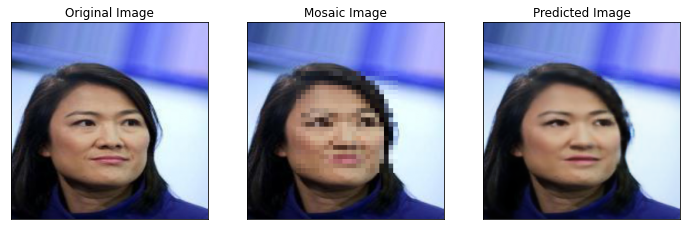

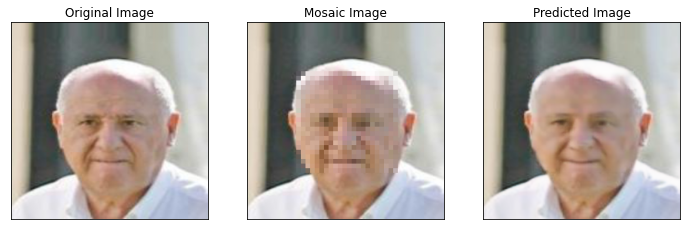

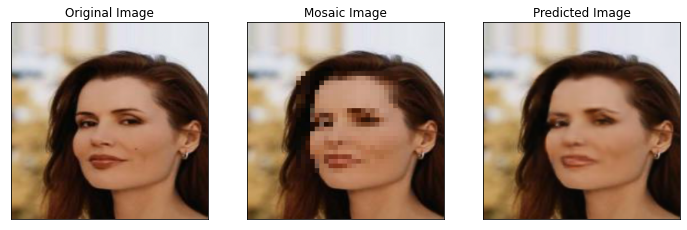

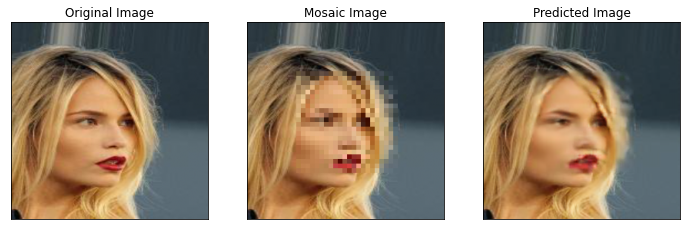

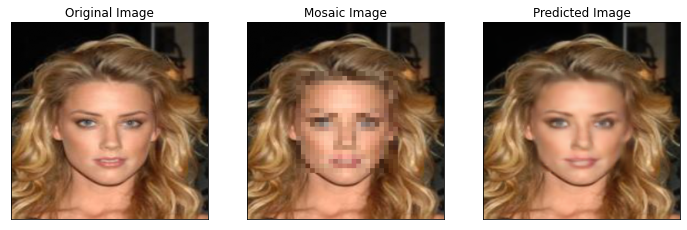

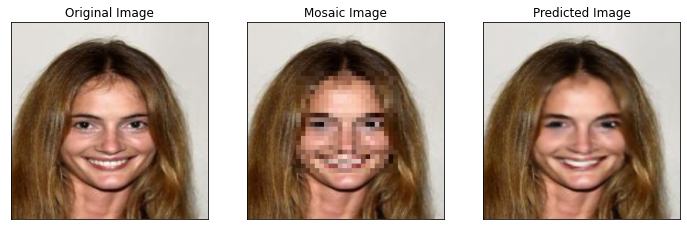

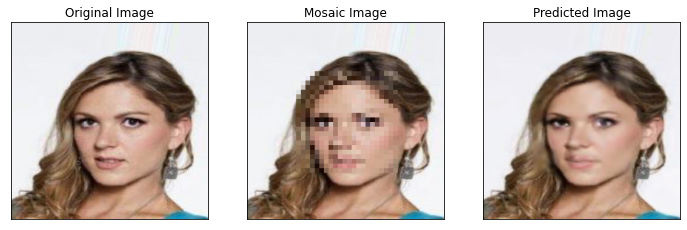

In [ ]:
for img_idx in [0] + list(range(6 , 20)):
    img_pred =  sess.run(fake_img , 
                feed_dict = {mosaic_img : np.expand_dims((mosaic_test[img_idx] - 127.5) / 127.5 , axis = 0)  ,
                        on_train : False , 
                        keep_prob : 1})

    fig , ax = plt.subplots(1 , 3 , figsize = (12 , 12))

    ax[0].imshow(real_test[img_idx] / 255.)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original Image')

    ax[1].imshow(mosaic_test[img_idx] / 255.)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Mosaic Image')

    ax[2].imshow((img_pred[0] + 1) * 127.5 / 255)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title('Predicted Image')

np.save('img_pred' , img_pred)
del mosaic_test , real_test

In [ ]:
saver = tf.train.Saver()
saver.save(sess , 'mosaic_model/mosaic_model')
print('Model Trained and Saved')

Model Trained and Saved
